<a href="https://colab.research.google.com/github/arzoozehra/CIND820/blob/main/hypertuned_MLP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
!pip install contractions
import contractions
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
#!pip install pyspellchecker
#from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 6.0 MB/s 
     |████████████████████████████████| 110 kB 41.9 MB/s 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


**Load and preprocess data**

In [2]:
url = "https://raw.githubusercontent.com/arzoozehra/CIND820/main/data/train.csv"
train = pd.read_csv(url)
test = pd.read_csv("https://raw.githubusercontent.com/arzoozehra/CIND820/main/data/test.csv")

# Drop unnecessary columns
train.drop(["textID", "selected_text"], axis=1, inplace=True)
test.drop(["textID"], axis=1, inplace=True)

# Remove row with missing values
train.dropna(inplace=True)

In [3]:
print(train["text"].head(10))
print(train["text"].tail(10))

0                  I`d have responded, if I were going
1        Sooo SAD I will miss you here in San Diego!!!
2                            my boss is bullying me...
3                       what interview! leave me alone
4     Sons of ****, why couldn`t they put them on t...
5    http://www.dothebouncy.com/smf - some shameles...
6    2am feedings for the baby are fun when he is a...
7                                           Soooo high
8                                          Both of you
9     Journey!? Wow... u just became cooler.  hehe....
Name: text, dtype: object
27471    i`m defying gravity. and nobody in alll of oz,...
27472    http://twitpic.com/663vr - Wanted to visit the...
27473     in spoke to you yesterday and u didnt respond...
27474    So I get up early and I feel good about the da...
27475                                       enjoy ur night
27476     wish we could come see u on Denver  husband l...
27477     I`ve wondered about rake to.  The client has ...
27478     Y

**Clean data**

In [4]:
def clean_data(data):
  
  # Convert text to lowercase
  data["text"] = data["text"].str.lower()

  # Expand contractions e.g "gonna" to "going to" and "i've" to "i have"
  data["text"].replace( {r"`": "'"}, inplace= True, regex = True)
  data["text"] = data["text"].apply(contractions.fix)

  # Remove @, Unicode characters, punctuation, emojis, URLs, retweets, words with digits, and 1 or 2 letter words
  data["text"].replace( {r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?|\w*\d\w*|\b\w{1,2}\b": " "}, inplace= True, regex = True)

  # Remove extra whitespaces
  data["text"].replace( {r" +": " "}, inplace= True, regex = True)
  data["text"] = data["text"].str.strip()

  # Correct spellings
  #spell = SpellChecker()

  #def correct_spellings(text):
  #    corrected_text = []
  #    misspelled_words = {}
  #    words = text.split()
  #    for w in spell.unknown(words):
  #        corr = spell.correction(w)
  #        if corr:
  #            misspelled_words[w] = spell.correction(w) or w
  #    corrected_text = [misspelled_words.get(w, w) for w in words]
  #    return " ".join(corrected_text)

  #data["text"] = data["text"].apply(lambda x : correct_spellings(x))

  # Remove stopwords
  stop = stopwords.words("english")
  data["text"] = data["text"].apply(lambda text: " ".join([word for word in text.split() if word not in (stop)]))

  # Stemming
  stemmer = PorterStemmer()
  data["text"] = data["text"].apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))

  # Lemmatizing
  lemmatizer = WordNetLemmatizer()
  data["text"] = data["text"].apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))

  return data

In [5]:
#Clean trraining data
train = clean_data(train)

#Clean testing data
test = clean_data(test)

In [6]:
print(train["text"].head(10))
print(train["text"].tail(10))

0                          would respond go
1                   sooo sad miss san diego
2                                 bos bulli
3                       interview leav alon
4       son could put releas alreadi bought
5    shameless plug best ranger forum earth
6                   feed babi fun smile coo
7                                soooo high
8                                          
9     journey wow becam cooler hehe possibl
Name: text, dtype: object
27471        defi graviti nobodi alll wizard ever go bring
27472                                 want visit anim late
27473           spoke yesterday respond girl wassup though
27474    get earli feel good day walk work feel alright...
27475                                          enjoy night
27476    wish could come see denver husband lost job ca...
27477    wonder rake client made clear net forc dev lea...
27478    yay good enjoy break probabl need hectic weeke...
27479                                                worth
274

**Vectorize text using TF-IDF**

In [7]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)  # Use 1-grams + 2-grams.

# Whether text should be split into word or character n-grams.
TOKEN_MODE = "word" # Split text into word tokens.

# Minimum document frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 5

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000


def ngram_vectorize(train_texts, train_labels, test_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        test_texts: list, test text strings.

    # Returns
        train_vectors, test_vectors: vectorized training and test texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            "ngram_range": NGRAM_RANGE,
            "analyzer": TOKEN_MODE,  
            "min_df": MIN_DOCUMENT_FREQUENCY,
            "max_df" : 0.8,
            "max_features" : TOP_K,
            "sublinear_tf": "True"
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    train_vectors = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    test_vectors = vectorizer.transform(test_texts)

    return train_vectors, test_vectors

In [8]:
# Create feature vectors
train_vectors, test_vectors = ngram_vectorize(train["text"], train["sentiment"], test["text"])

**MLP modelling and evaluation**


In [9]:
model = MLPClassifier()
model_name = "MLP"

# 5-fold Cross-validation
k = 5
cv_df = pd.DataFrame(index=range(k))
entries = []
accuracies = cross_val_score(model, train_vectors, train["sentiment"], scoring="accuracy", cv=k)
for fold_id, accuracy in enumerate(accuracies):
  entries.append((fold_id, accuracy))

cv_df = pd.DataFrame(entries, columns=["fold_id", "accuracy"])

In [10]:
mean_accuracy = cv_df.accuracy.mean()
std_accuracy = cv_df.accuracy.std()

acc = pd.DataFrame([[mean_accuracy,std_accuracy]], columns = ["Accuracy", " Std dev"])
print(acc)

   Accuracy   Std dev
0  0.643086   0.00503


In [11]:
model = MLPClassifier()
model.fit(train_vectors, train["sentiment"])
prediction = model.predict(test_vectors)
print(f"Test set accuracy: {accuracy_score(test['sentiment'], prediction) * 100} %\n")

Test set accuracy: 65.81777023203169 %



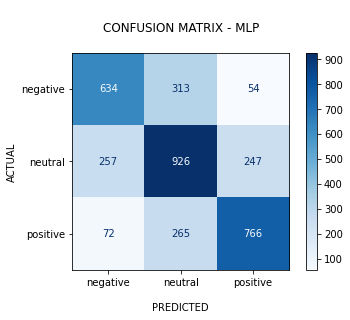

In [12]:
data = confusion_matrix(test["sentiment"], prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=data, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.ylabel("ACTUAL")
plt.xlabel("\nPREDICTED")
plt.title(f"\nCONFUSION MATRIX - {model_name}\n");
plt.show()

In [13]:
# Classification report
print(f"\tCLASSIFICATIION METRICS - {model_name}\n")
print(classification_report(test["sentiment"], prediction, target_names= ["negative", "neutral", "positive"]))

	CLASSIFICATIION METRICS - MLP

              precision    recall  f1-score   support

    negative       0.66      0.63      0.65      1001
     neutral       0.62      0.65      0.63      1430
    positive       0.72      0.69      0.71      1103

    accuracy                           0.66      3534
   macro avg       0.66      0.66      0.66      3534
weighted avg       0.66      0.66      0.66      3534



**Tuning hyperparameters of the model**

In [44]:
param_grid = {"hidden_layer_sizes": [(50, 50), (50,50,50), (50,100,50), (256,128,64,32), (1000,)],
              "alpha": [0.00001, 0.01, 1]
             }

In [45]:
random_search = RandomizedSearchCV(MLPClassifier(early_stopping=True), param_grid, refit = True, verbose = 5)
random_search.fit(train_vectors, train["sentiment"])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END alpha=1, hidden_layer_sizes=(50, 50);, score=0.703 total time=  32.1s
[CV 2/5] END alpha=1, hidden_layer_sizes=(50, 50);, score=0.693 total time= 1.2min
[CV 3/5] END alpha=1, hidden_layer_sizes=(50, 50);, score=0.715 total time=  58.7s
[CV 4/5] END alpha=1, hidden_layer_sizes=(50, 50);, score=0.709 total time=  28.6s
[CV 5/5] END alpha=1, hidden_layer_sizes=(50, 50);, score=0.713 total time=  34.1s
[CV 1/5] END alpha=1, hidden_layer_sizes=(256, 128, 64, 32);, score=0.699 total time= 2.2min
[CV 2/5] END alpha=1, hidden_layer_sizes=(256, 128, 64, 32);, score=0.688 total time= 1.7min
[CV 3/5] END alpha=1, hidden_layer_sizes=(256, 128, 64, 32);, score=0.714 total time= 2.0min
[CV 4/5] END alpha=1, hidden_layer_sizes=(256, 128, 64, 32);, score=0.701 total time= 1.8min
[CV 5/5] END alpha=1, hidden_layer_sizes=(256, 128, 64, 32);, score=0.705 total time= 2.3min
[CV 1/5] END alpha=0.01, hidden_layer_sizes=(50, 100, 50);,

RandomizedSearchCV(estimator=MLPClassifier(early_stopping=True),
                   param_distributions={'alpha': [1e-05, 0.01, 1],
                                        'hidden_layer_sizes': [(50, 50),
                                                               (50, 50, 50),
                                                               (50, 100, 50),
                                                               (256, 128, 64,
                                                                32),
                                                               (1000,)]},
                   verbose=5)

In [46]:
print(random_search.best_params_)

{'hidden_layer_sizes': (50, 50), 'alpha': 1}


In [47]:
print(random_search.best_estimator_)

MLPClassifier(alpha=1, early_stopping=True, hidden_layer_sizes=(50, 50))


In [48]:
print(random_search.best_score_)

0.7066957787481805


**Evaluating the model with best parameters**

In [49]:
random_predictions = random_search.best_estimator_.predict(train_vectors)
print(accuracy_score(train["sentiment"], random_predictions))

0.766703056768559


In [50]:
random_predictions = random_search.best_estimator_.predict(test_vectors)
print(accuracy_score(test["sentiment"], random_predictions))

0.7176004527447651


In [51]:
print(confusion_matrix(test["sentiment"], random_predictions))

[[ 613  348   40]
 [ 157 1123  150]
 [  28  275  800]]


In [52]:
print(classification_report(test["sentiment"], random_predictions))

              precision    recall  f1-score   support

    negative       0.77      0.61      0.68      1001
     neutral       0.64      0.79      0.71      1430
    positive       0.81      0.73      0.76      1103

    accuracy                           0.72      3534
   macro avg       0.74      0.71      0.72      3534
weighted avg       0.73      0.72      0.72      3534



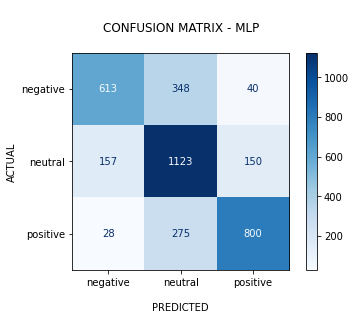

In [53]:
data = confusion_matrix(test["sentiment"], random_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=data, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.ylabel("ACTUAL")
plt.xlabel("\nPREDICTED")
plt.title(f"\nCONFUSION MATRIX - {model_name}\n");
plt.show()

In [ ]:
#Tune
param_grid = {"hidden_layer_sizes": [(50,), (100,100), (500,500), (500,)],
              "alpha": [0.001, 0.01, 1]
             }

random_search = RandomizedSearchCV(MLPClassifier(early_stopping=True), param_grid, refit = True, verbose = 3)
random_search.fit(train_vectors, train["sentiment"])

In [ ]:
print(random_search.best_params_)

In [ ]:
print(random_search.best_estimator_)

In [ ]:
print(random_search.best_score_)

In [ ]:
#Eval
random_predictions = random_search.best_estimator_.predict(train_vectors)
print(accuracy_score(train["sentiment"], random_predictions))

In [ ]:
random_predictions = random_search.best_estimator_.predict(test_vectors)
print(accuracy_score(test["sentiment"], random_predictions))

In [ ]:
data = confusion_matrix(test["sentiment"], random_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=data, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.ylabel("ACTUAL")
plt.xlabel("\nPREDICTED")
plt.title(f"\nCONFUSION MATRIX - {model_name}\n");
plt.show()

In [ ]:
print(classification_report(test["sentiment"], random_predictions))